# Plots for logistic regression standard training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dotenv
import pandas as pd
import mlflow
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots
import plotly.io as pio
import matplotlib.lines

import typing
import os
import shutil
import sys

In [2]:
EXPORT = False
SHOW_TITLES = not EXPORT
EXPERIMENT_NAME = 'logistic_regression_standard_training'

In [3]:
# Load environment variables
dotenv.load_dotenv()

# Enable loading of the project module
MODULE_DIR = os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, os.pardir)), 'src')
sys.path.append(MODULE_DIR)

In [4]:
%load_ext autoreload
%autoreload 2
import interpolation_robustness as ir

In [5]:
FIGURE_SIZE = (2.6, 1.4)
LEGEND_FIGURE_SIZE = (3.9, 0.4)
LEGEND_FONT_SIZE = ir.plots.FONT_SIZE_SMALL_PT

ir.plots.setup_matplotlib(show_titles=SHOW_TITLES)

In [6]:
if EXPORT:
    EXPORT_DIR = os.path.join(ir.util.REPO_ROOT_DIR, 'logs', f'export_{EXPERIMENT_NAME}')
    print('Using export directory', EXPORT_DIR)
    if os.path.exists(EXPORT_DIR):
        shutil.rmtree(EXPORT_DIR)
    os.makedirs(EXPORT_DIR)

def export_fig(fig: plt.Figure, filename: str):
    # If export is disabled then do nothing
    if EXPORT:
        export_path = os.path.join(EXPORT_DIR, filename)
        fig.savefig(export_path)
        print('Exported figure at', export_path)


## Load experiment data

In [7]:
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name(EXPERIMENT_NAME)
runs = mlflow.search_runs(
    experiment.experiment_id
)
runs = runs.set_index('run_id', drop=False)  # set index, but keep column to not break stuff depending on it

# Convert some parameters to numbers and sort accordingly
runs['params.data_dim'] = runs['params.data_dim'].astype(int)
runs['params.train_attack_epsilon'] = runs['params.train_attack_epsilon'].astype(np.float)
runs['params.test_attack_epsilon'] = runs['params.test_attack_epsilon'].astype(np.float)
runs['params.l2_lambda'] = runs['params.l2_lambda'].astype(np.float)
runs = runs.sort_values(['params.data_dim', 'params.l2_lambda'])
print('Loaded', len(runs), 'runs')
assert runs['status'].eq('FINISHED').all()
assert runs['params.train_attack_epsilon'].eq(0).all()
assert runs['params.label_noise'].eq('0.0').all()

Loaded 456 runs


## Plots

In [8]:
std_risk_color_idx = 0
robust_risk_color_idx = 1
data_dims = runs['params.data_dim'].unique()
test_attack_epsilon, = runs['params.test_attack_epsilon'].astype(int).unique()
num_samples, = runs['params.data_num_train_samples'].astype(int).unique()
BASELINE_LAMBDA = 0.0

In [9]:
noreg_runs = runs[runs['params.l2_lambda'] == BASELINE_LAMBDA]
bestreg_runs = runs.groupby('params.data_dim').aggregate({'metrics.true_std_risk': 'min', 'metrics.true_robust_risk': 'min'})

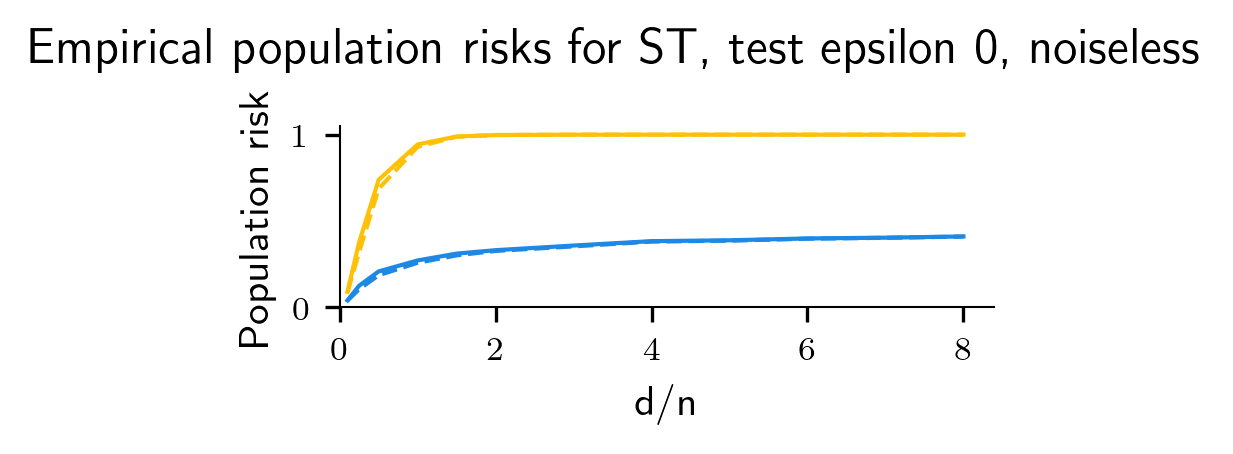

In [10]:
fig, ax = plt.subplots(figsize=FIGURE_SIZE)

# Standard risk
ax.plot(
    noreg_runs['params.data_dim'] / float(num_samples),
    noreg_runs['metrics.true_std_risk'],
    label=fr'Std., $\lambda \to 0$',
    c=f'C{std_risk_color_idx}',
    ls='-'
)
ax.plot(
    bestreg_runs.index / float(num_samples),
    bestreg_runs['metrics.true_std_risk'],
    label=r'Std., $\lambda_{\textnormal{opt}}$',
    c=f'C{std_risk_color_idx}',
    ls='--'
)

# Robust risk
ax.plot(
    noreg_runs['params.data_dim'] / float(num_samples),
    noreg_runs['metrics.true_robust_risk'],
    label=fr'Robust, $\lambda \to 0$',
    c=f'C{robust_risk_color_idx}',
    ls='-'
)
ax.plot(
    bestreg_runs.index / float(num_samples),
    bestreg_runs['metrics.true_robust_risk'],
    label=r'Robust, $\lambda_{\textnormal{opt}}$',
    c=f'C{robust_risk_color_idx}',
    ls='--'
)

ax.set_xlabel('d/n')
ax.set_ylabel('Population risk')
ax.set_ylim(bottom=0)
ax.set_xlim(left=0.0)

if SHOW_TITLES:
    fig.suptitle(f'Empirical population risks for ST, test epsilon {test_attack_epsilon}, noiseless')

export_fig(fig, f'logreg_standard_training.pdf')
plt.show()

In [11]:
# Legend
legend_fig = plt.figure(figsize=LEGEND_FIGURE_SIZE)
handles, labels = ax.get_legend_handles_labels()
ir.plots.errorbar_legend(
    legend_fig,
    handles=handles,
    labels=labels,
    loc='center',
    ncol=4,
    mode='expand',
    frameon=True,
    fontsize=LEGEND_FONT_SIZE,
    borderpad=0.5
)

export_fig(legend_fig, f'logreg_standard_training_legend.pdf')


<Figure size 1170x120 with 0 Axes>